In [81]:
from IPython.display import Image

import pandas as pd
import numpy as np
from pprint import pprint
import collections

import os, sys
file_dir = '/Users/imsoyoung/Soyoung/Ajou/Project/DigitalPhenotype/DigitalPhenotype_overall/Code/Util'
sys.path.append(os.path.dirname(os.path.abspath
                                (os.path.abspath(file_dir))))

import Util.Utility as util


%matplotlib inline
import matplotlib.pylab as plt
import datetime 
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

# !pip install networkx
import networkx as nx


***IDEA from KDD paper***

- Action Graph :  a weighted, directed graph for capturing individual user’s in-app action transition patterns


- 사용자의 ***앱 사용***을 Action Graph 로 표현할 수 있다면?


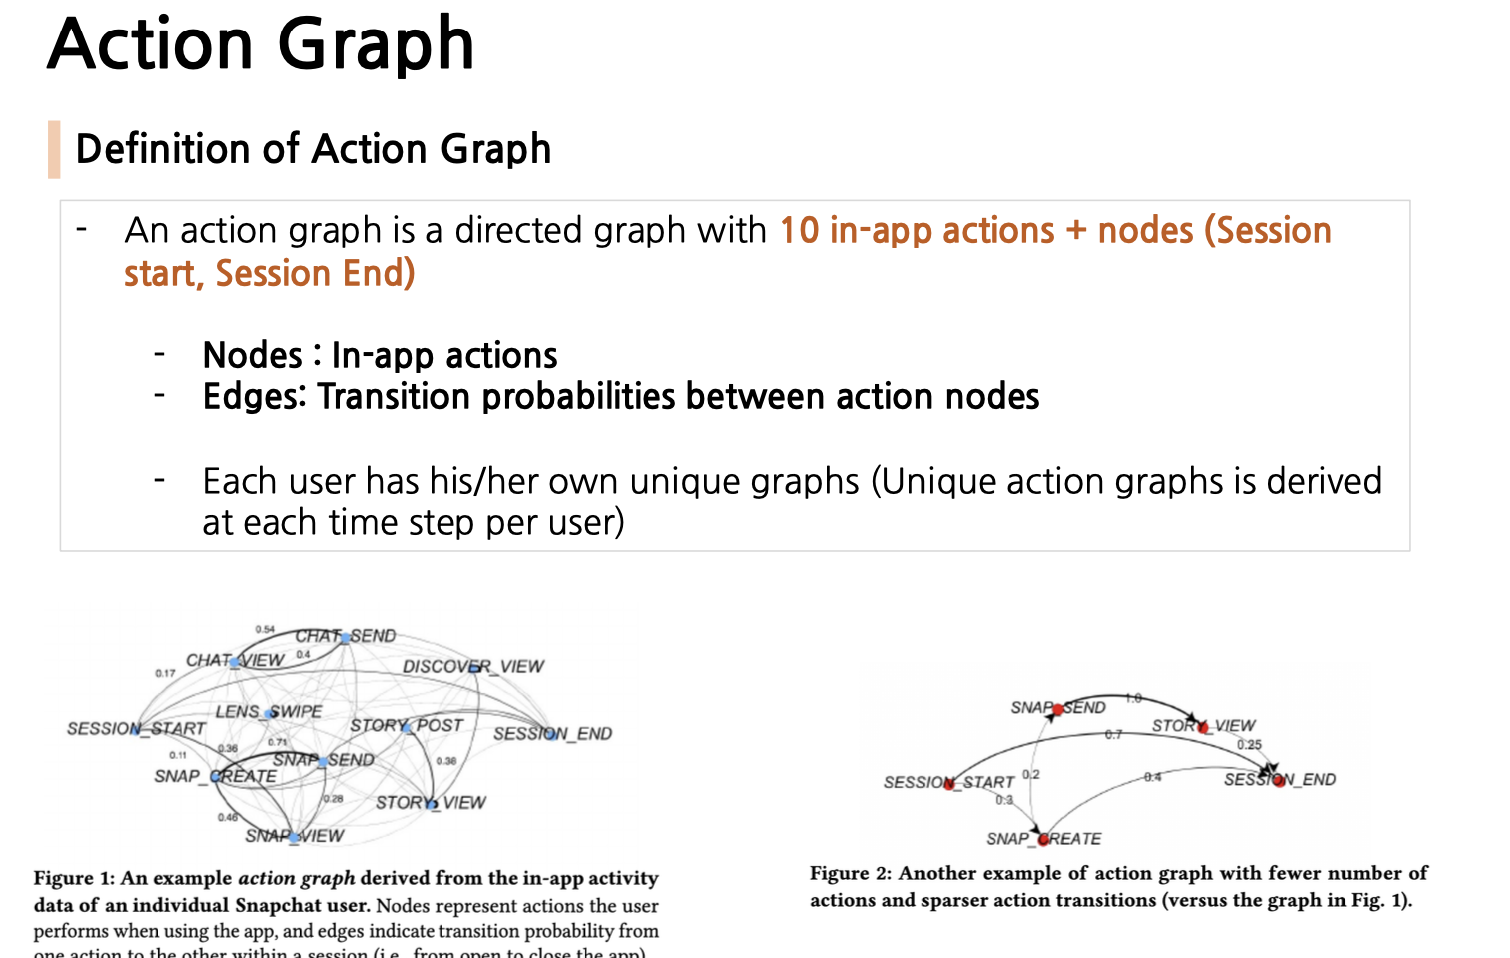

In [19]:
Image("../../img/DP_ActionGraph.png") 

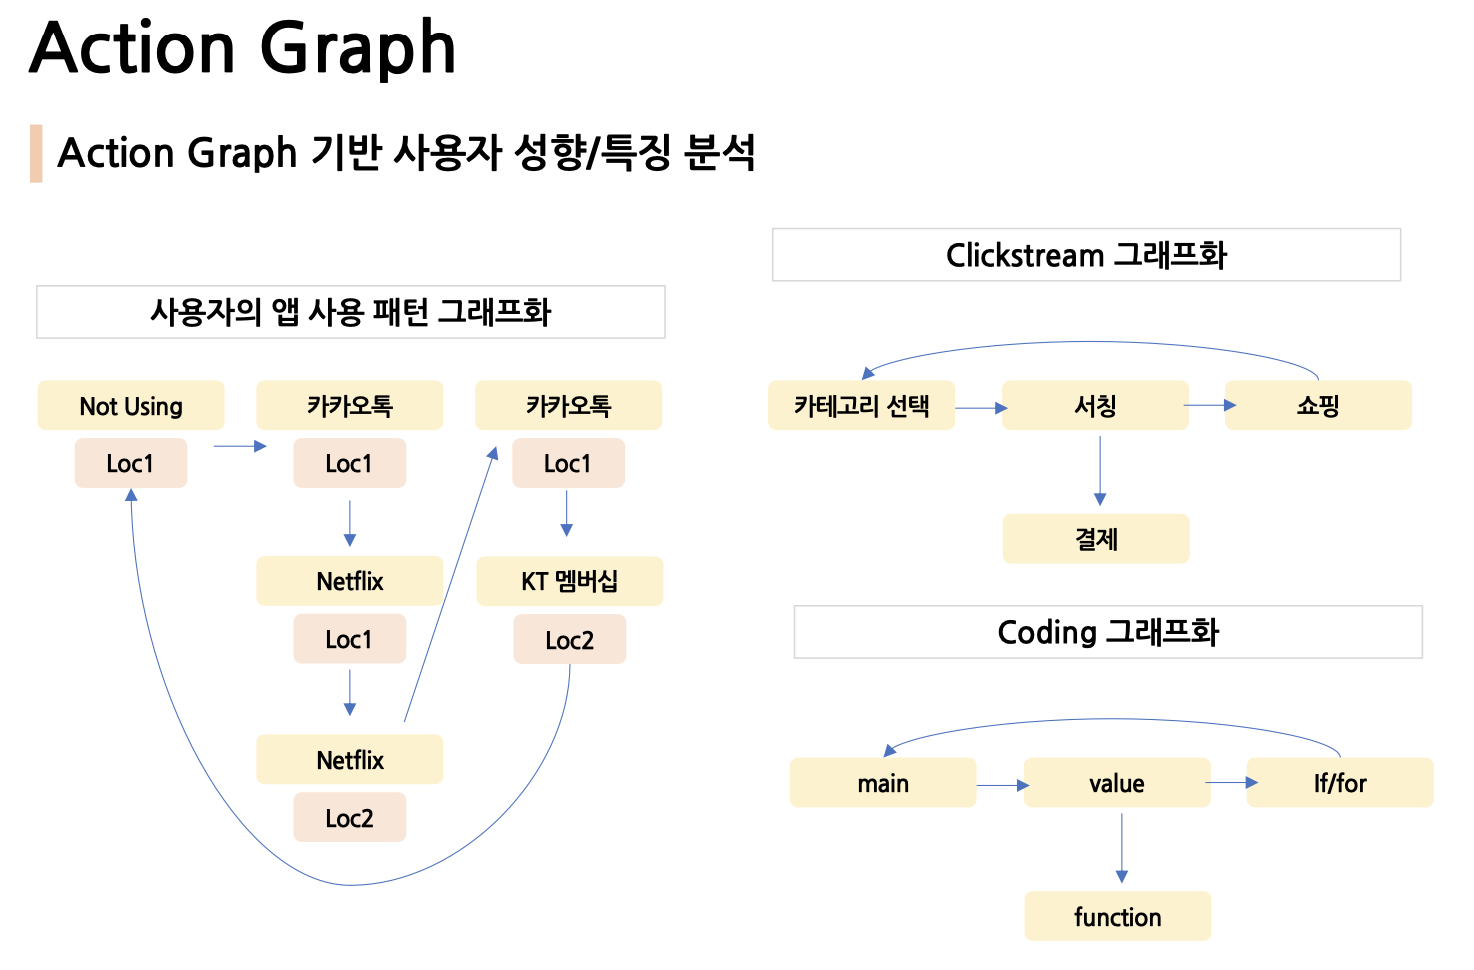

In [16]:
Image("../../img/DP_ActionGraph_adopt.png") 

In [6]:
app = pd.read_csv('../01.Preprocess/result/A_categorized.csv')
util.toDatetime(app, ['date'], '%Y%m%d')
app.head(3)

,Unnamed: 0,_id,uid,date,stime,etime,packageName,total,isInUsable,packageFullName,category
0,2,3,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:11:59,2018-12-03 00:12:10,캐시워크,11,True,com.cashwalk.cashwalk,Health & Fitness
1,17,20,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:13:21,2018-12-03 00:13:24,카카오톡,3,True,com.kakao.talk,Communication
2,19,22,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:13:32,2018-12-03 00:13:33,카카오톡,1,True,com.kakao.talk,Communication


# App Category 전처리

- LDA 분석시, Communication 의 비율이 너무 큼
    - Communication --> Chatting / SNS 분리
    
    
- Background, Health & Fitness 제거
    - Background 에서 작동하는 앱 제거
  

In [36]:
app['category'] = app.apply(lambda row : 'Chat' if row['packageName'] == '카카오톡' else row['category'], axis=1)

count = app.groupby('category')['total'].count().reset_index()
count.sort_values(by='total', ascending=False)
count.head()


,category,total
0,Background,432
1,Books & Reference,7
2,Business,6
3,Chat,1584
4,Comics,139


In [37]:
print(set(app[app['category']=='Communication']['packageName']))

app[app['category']=='Communication'].groupby('packageName')['total'].count()

{'Chrome', 'Gmail', '에브리타임', '아주톡톡', 'Facebook', 'Messenger', 'NAVER', 'Instagram', 'Between', 'BAND'}


packageName
BAND           8
Between        1
Chrome        54
Facebook     572
Gmail         33
Instagram     13
Messenger      5
NAVER        171
아주톡톡           1
에브리타임        162
Name: total, dtype: int64

In [38]:
app_sub = app[~app['category'].isin(['Health & Fitness', 'Background'])]

# Count Transition

In [43]:
app_sub['next_category'] = app_sub['category'].shift(-1)
app_sub['transition'] = app_sub.apply(lambda row: True if row['category']!= row['next_category'] else False, axis=1)
app_sub.head()

/Users/imsoyoung/opt/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/imsoyoung/opt/anaconda3/envs/tensorflow1/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Unnamed: 0,_id,uid,date,stime,etime,packageName,total,isInUsable,packageFullName,category,next_category,transition
1,17,20,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:13:21,2018-12-03 00:13:24,카카오톡,3,True,com.kakao.talk,Chat,Chat,False
2,19,22,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:13:32,2018-12-03 00:13:33,카카오톡,1,True,com.kakao.talk,Chat,Chat,False
3,55,70,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:24:26,2018-12-03 00:24:53,카카오톡,27,True,com.kakao.talk,Chat,Communication,True
4,82,113,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:33:29,2018-12-03 00:42:48,Facebook,559,True,com.facebook.katana,Communication,Chat,True
5,108,151,otfKOMf7VUaB5lxUARO0HNusxPB2,2018-12-03,2018-12-03 00:49:58,2018-12-03 00:50:08,카카오톡,10,True,com.kakao.talk,Chat,Chat,False


In [48]:
cat_list = list(set(app_sub['category']))

In [49]:
def getTransOfCat(df, current_cat):
    cat_counts = collections.defaultdict(int)
    df_sub = df[df['category'] == current_cat]
    for cat in cat_list:
        if cat != current_cat:
            df_cat = df_sub[df_sub['next_category'] == cat]['category'].count()
            cat_counts[cat] += df_cat        
        else:
            cat_counts[cat] = 0
    return cat_counts

In [54]:
cat_list = list(set(app_sub['category']))

trans_df = pd.DataFrame(index = cat_list, columns = cat_list)
print(trans_df.shape)

for idx in trans_df.index:
    trans_df.loc[idx] = getTransOfCat(app_sub, idx)
    # getTransOfCat(app_sub, 'Chat')

(15, 15)


In [62]:
trans_df['row_sum'] = trans_df.sum(axis=1)
trans_df

,Music,Photography,Chat,Productivity,Food & Drink,Business,Shopping,Travel & Local,Finance,Comics,Entertainment,Communication,Lifestyle,Education,Books & Reference,row_sum
Music,0,2,33,0,0,0,0,2,1,0,1,11,0,3,0,318.0
Photography,0,0,48,4,0,0,0,1,1,1,0,15,0,1,0,426.0
Chat,31,45,0,19,1,3,27,13,24,30,21,334,2,36,3,3534.0
Productivity,0,4,21,0,0,0,0,0,0,1,1,27,0,3,0,342.0
Food & Drink,0,0,2,0,0,0,0,0,4,0,1,3,0,0,0,60.0
Business,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,18.0
Shopping,1,0,22,0,0,0,0,3,0,0,0,18,0,2,0,276.0
Travel & Local,2,0,15,0,0,0,0,0,0,0,0,5,1,1,1,150.0
Finance,1,0,20,2,5,0,0,0,0,1,2,10,0,0,0,246.0
Comics,2,1,24,1,0,0,2,0,1,0,4,12,0,2,0,294.0


# Transition Ratio

In [77]:
print(trans_df.shape)

trans_ratio = trans_df.copy()

for col in trans_ratio.columns:
    trans_ratio[col] /= trans_ratio['row_sum']
    
trans_ratio

(15, 16)


,Music,Photography,Chat,Productivity,Food & Drink,Business,Shopping,Travel & Local,Finance,Comics,Entertainment,Communication,Lifestyle,Education,Books & Reference,row_sum
Music,0,0.00628931,0.103774,0,0,0,0,0.00628931,0.00314465,0,0.00314465,0.0345912,0,0.00943396,0,1.0
Photography,0,0,0.112676,0.00938967,0,0,0,0.00234742,0.00234742,0.00234742,0,0.0352113,0,0.00234742,0,1.0
Chat,0.00877193,0.0127334,0,0.00537634,0.000282965,0.000848896,0.00764007,0.00367855,0.00679117,0.00848896,0.00594228,0.0945105,0.000565931,0.0101868,0.000848896,1.0
Productivity,0,0.0116959,0.0614035,0,0,0,0,0,0,0.00292398,0.00292398,0.0789474,0,0.00877193,0,1.0
Food & Drink,0,0,0.0333333,0,0,0,0,0,0.0666667,0,0.0166667,0.05,0,0,0,1.0
Business,0,0,0.111111,0,0,0,0,0,0,0,0,0.0555556,0,0,0,1.0
Shopping,0.00362319,0,0.0797101,0,0,0,0,0.0108696,0,0,0,0.0652174,0,0.00724638,0,1.0
Travel & Local,0.0133333,0,0.1,0,0,0,0,0,0,0,0,0.0333333,0.00666667,0.00666667,0.00666667,1.0
Finance,0.00406504,0,0.0813008,0.00813008,0.0203252,0,0,0,0,0.00406504,0.00813008,0.0406504,0,0,0,1.0
Comics,0.00680272,0.00340136,0.0816327,0.00340136,0,0,0.00680272,0,0.00340136,0,0.0136054,0.0408163,0,0.00680272,0,1.0


In [79]:
del trans_ratio['row_sum']

trans_ratio.head()
trans_ratio = trans_ratio.apply(pd.to_numeric)
trans_ratio.shape

(15, 15)

In [89]:
trans_ratio.describe()

,Music,Photography,Chat,Productivity,Food & Drink,Business,Shopping,Travel & Local,Finance,Comics,Entertainment,Communication,Lifestyle,Education,Books & Reference
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.003372,0.003052,0.079983,0.002958,0.001615,0.000057,0.001360,0.001686,0.005871,0.002082,0.003898,0.055108,0.000482,0.004596,0.000548
std,0.004390,0.004328,0.041327,0.003739,0.005222,0.000219,0.002833,0.003146,0.016939,0.002732,0.005475,0.038114,0.001717,0.004503,0.001715
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.066865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034901,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.081633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043590,0.000000,0.004902,0.000000
75%,0.005677,0.004677,0.109402,0.005252,0.000141,0.000000,0.000000,0.002224,0.003148,0.003495,0.006998,0.062483,0.000000,0.008009,0.000000
max,0.013333,0.012733,0.138889,0.009804,0.020325,0.000849,0.007640,0.010870,0.066667,0.008489,0.016667,0.166667,0.006667,0.012579,0.006667


# Draw Graph (Network)

- NetworkX 이용

    - cf. https://frhyme.github.io/python-lib/draw_network(study)/#draw-just-one-network
    - cf. https://www.slideshare.net/koorukuroo/20140830-pycon2014-networkx

In [70]:
# np.matrix(trans_ratio)

## Simple Graph

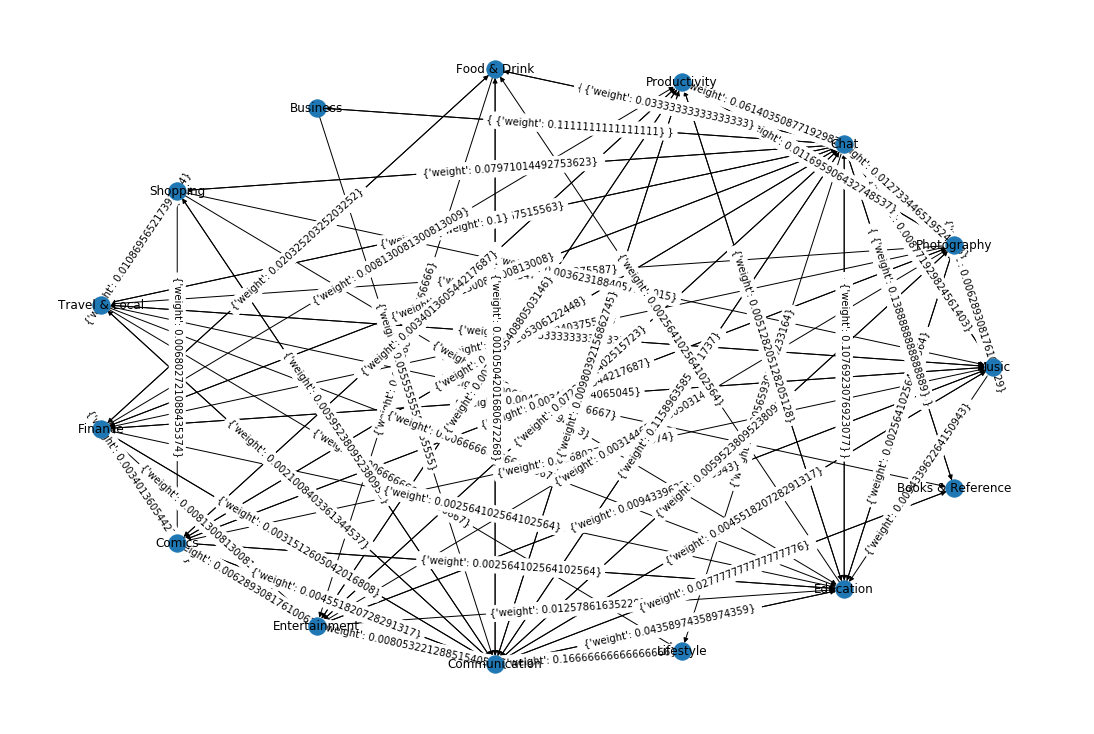

In [91]:
trans_array = trans_ratio.to_numpy()

G = nx.from_numpy_matrix(np.matrix(trans_ratio), create_using=nx.DiGraph)

labels={}
for k in range(15):
    labels[k]= trans_ratio.columns[k]
    
layout = nx.circular_layout(G)
nx.draw(G, layout)
# nx.draw_networkx_nodes(G, pos=layout, 
#                        nodelist = trans_ratio.columns, alpha=0.8)
nx.draw_networkx_labels(G, pos = layout, labels = labels)
nx.draw_networkx_edge_labels(G, pos=layout)
plt.show()



- 너무 작은 weight를 가지고 있는 edge는 모두 삭제

In [138]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

def draw_whole_graph(G):
    plt.figure(figsize=(16, 8))
    plt.margins(x=0.1, y=0.1)
    
#     pos = nx.spring_layout(G)
#     pos = graphviz_layout(G, prog='twopi', args='')
    
    pos = nx.circular_layout(G)

    nx.draw_networkx_nodes(
        G, pos ,node_size = [v*10000 for v in degree] , node_shape='h',
         cmap=plt.cm.Blues, alpha=0.9
                      )
    nx.draw_networkx_edges(
        G, pos, edge_color=[e[2]['weight'] for e in G.edges(data=True)],
        width=5, edge_cmap=plt.cm.Greys, style='dashed'
    )
    nx.draw_networkx_labels(
        G, pos, font_family='sans-serif', font_color='black', font_size=10, font_weight='bold'
    )
    plt.axis('off')
    plt.show()
    


In [106]:
trans_ratio["Music"]["Chat"]

0.008771929824561403

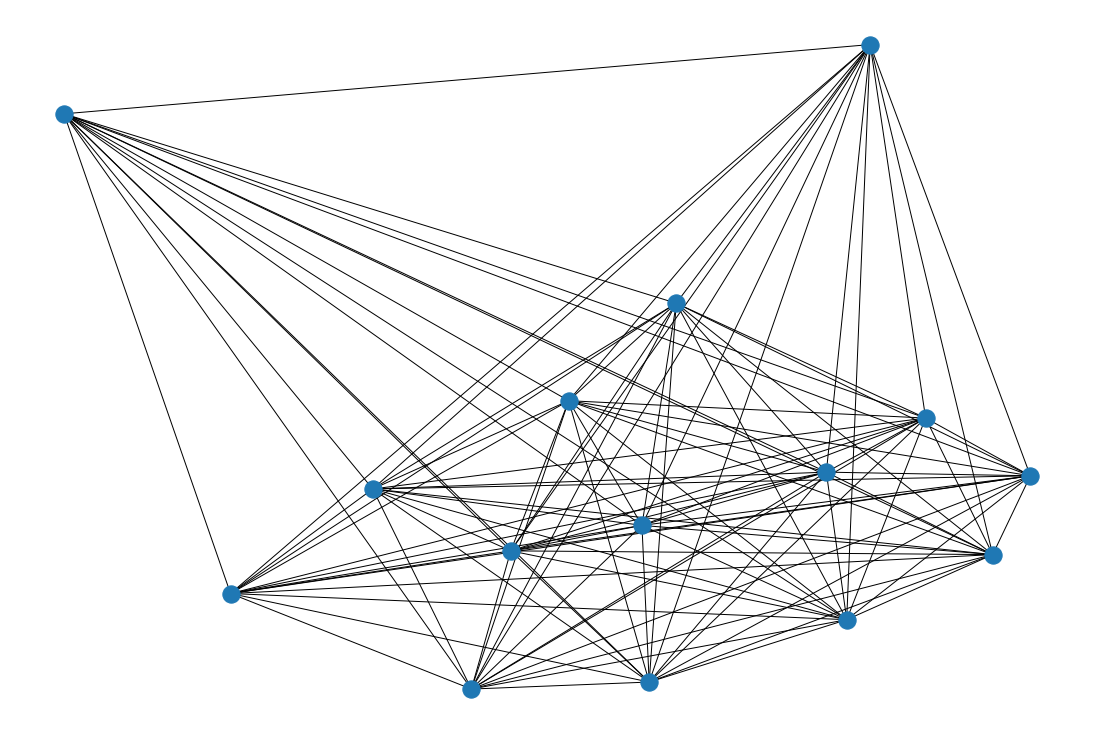

In [119]:
from itertools import permutations

G = nx.Graph()

category = trans_ratio.index

# NODE 추가 
G.add_nodes_from(category)

# Edge 추가 (+weight)
all_pair = list(permutations(category, 2))
for pair in all_pair:
    G.add_edge(pair[0], pair[1], weight =  trans_ratio[pair[0]][pair[1]])

G.edges(data=True)

# nx.draw_circular(G)
# nx.draw_spring(G)
pos = nx.spring_layout(G)
# print(pos)

nx.draw(G, pos)
 

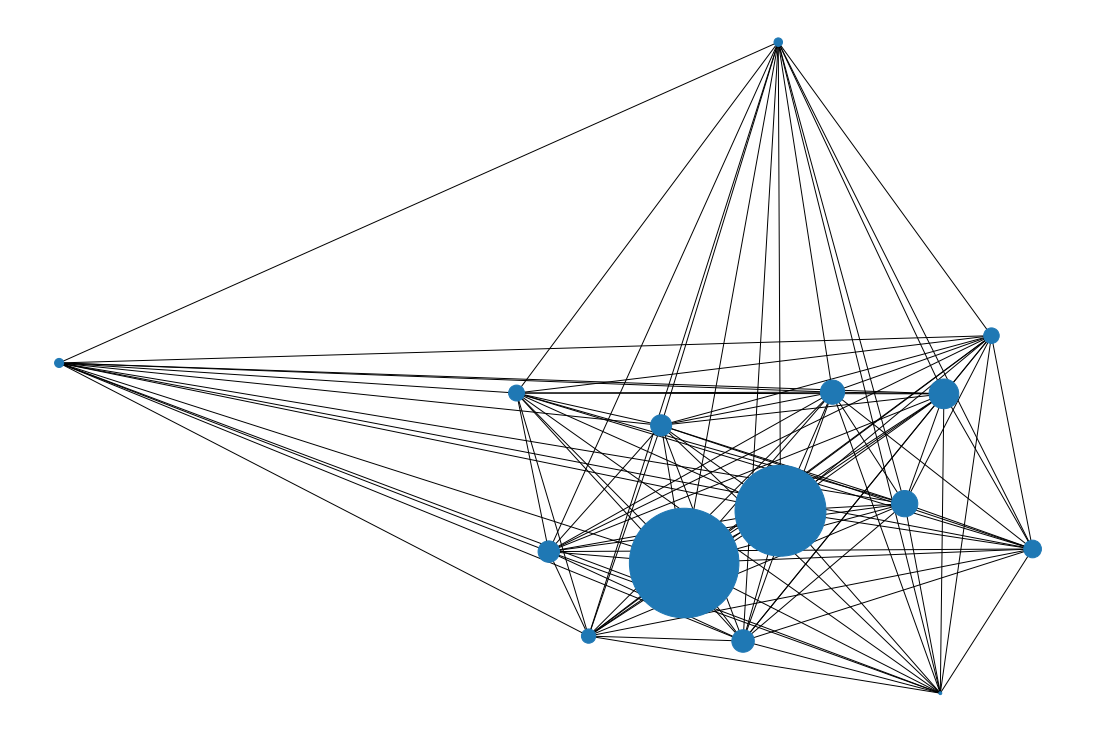

In [135]:
# Node 크기 결정 ==> col_sum 으로

degree = trans_ratio.sum().values
labels = trans_ratio.columns

nx.draw(G, node_size = [v*10000 for v in degree], nodelist=labels)

# labels_text = collections.defaultdict(str)
# for i,value in enumerate(labels):
#     labels_text[i] = value
    
# nx.draw_networkx_labels(G, pos, labels_text)

# nx.draw_networkx_edge_labels(G, pos=layout)

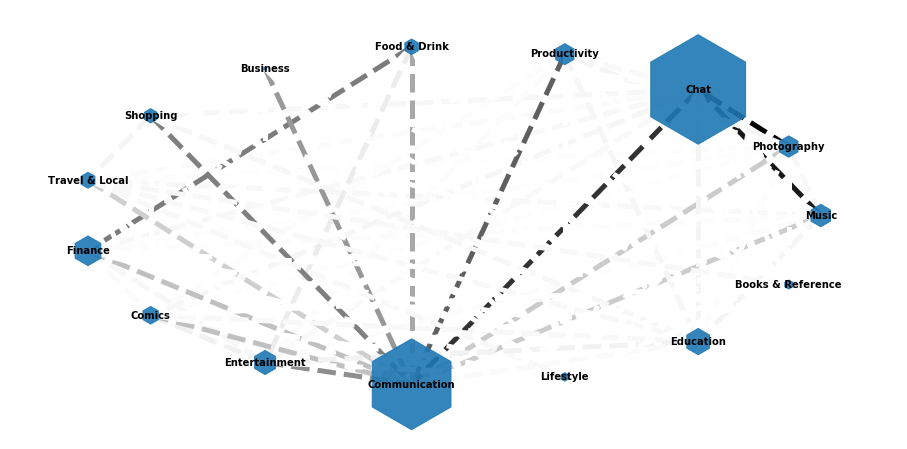

In [139]:
draw_whole_graph(G)